# The IRIS challenge

Task: find the model producing the highest classification accuracy

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

df = pd.read_csv('datasets/iris.csv')

## Data understanding

Hints
- There are 150 observations with 4 features each (sepal length, sepal width, petal length, petal width).
- Each observation is labelled with a `Species`

Take a first glance to the df
- Are the null values?
- Which are the attribute types?
- Which are the attribute ranges?
- How many labels?
- Are classes unbalanced? 

In [2]:
df

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [4]:
df.describe()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


In [5]:
df['Species'].value_counts()

Iris-virginica     50
Iris-versicolor    50
Iris-setosa        50
Name: Species, dtype: int64

### Summing up

| Question | Answer | Do we need action? |
| -        | -      | - |
| Are the null values? | No | No imputation |
|Which are the attribute types? | All attributes are numeric | No encoding | 
|Which are the attribute ranges? | Attribute ranges are similar | No normalization |
|How many labels? | 3 | - |
|Are classes unbalanced? | No, classess are equally distributed | No rebalancing |

IRIS is a simple dataset, it is useful for this lab but is not really representative for real-world ML tasks.

### Data visualization

Check the value distribution

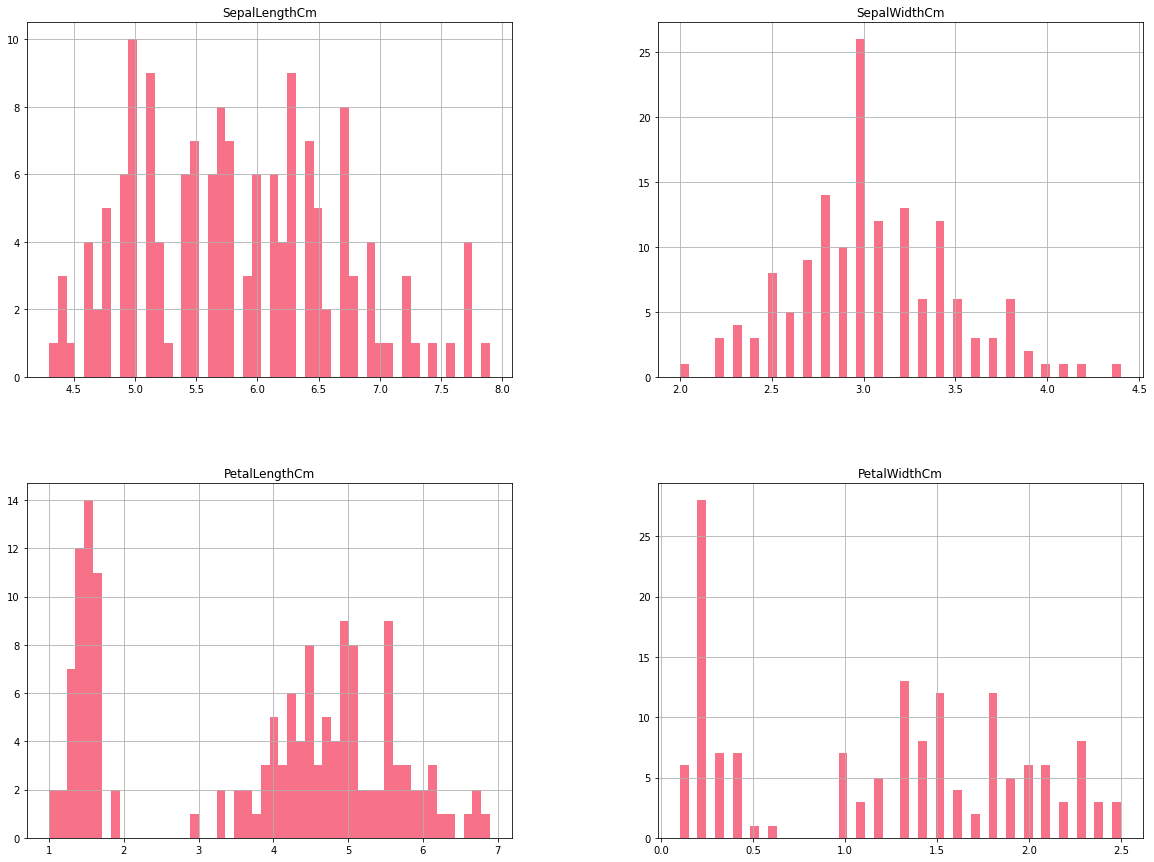

In [6]:
tmp = df.drop('Id', axis=1)
tmp.hist(bins=50, figsize=(20,15))
plt.show()

Check variable relationships

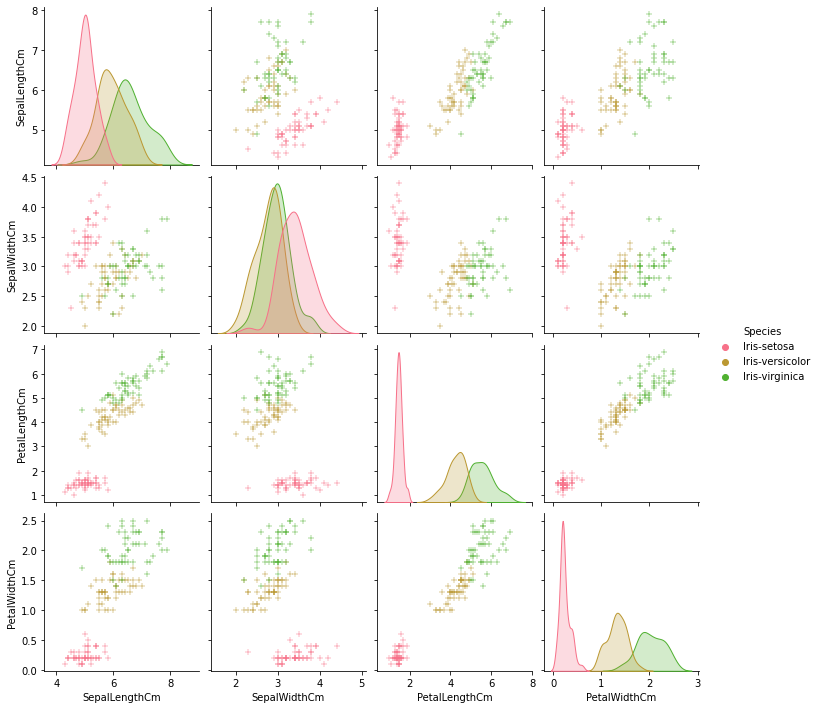

In [7]:
g = sns.pairplot(tmp, hue='Species', markers='+')
plt.show()

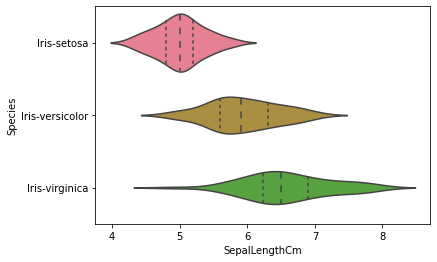

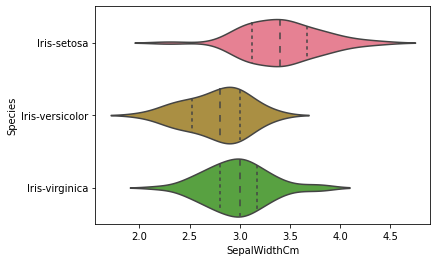

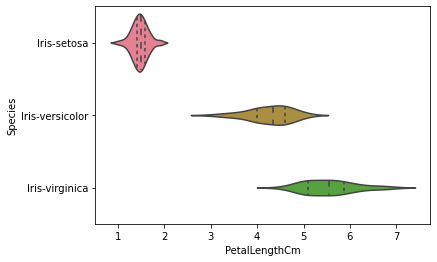

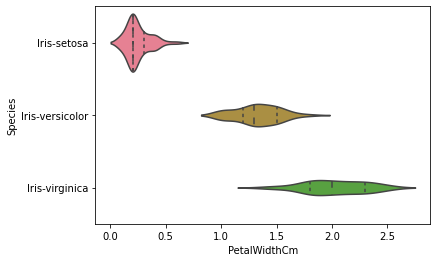

In [8]:
g = sns.violinplot(y='Species', x='SepalLengthCm', data=df, inner='quartile')
plt.show()
g = sns.violinplot(y='Species', x='SepalWidthCm', data=df, inner='quartile')
plt.show()
g = sns.violinplot(y='Species', x='PetalLengthCm', data=df, inner='quartile')
plt.show()
g = sns.violinplot(y='Species', x='PetalWidthCm', data=df, inner='quartile')
plt.show()

In [9]:
from scipy.stats import pearsonr
rho = tmp.corr(method ='pearson')
pval = tmp.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01, 0.05, 0.1] if x <= t]))
rho.round(2).astype(str) + p

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
SepalLengthCm,1.0***,-0.11,0.87***,0.82***
SepalWidthCm,-0.11,1.0***,-0.42***,-0.36***
PetalLengthCm,0.87***,-0.42***,1.0***,0.96***
PetalWidthCm,0.82***,-0.36***,0.96***,1.0***


<AxesSubplot:>

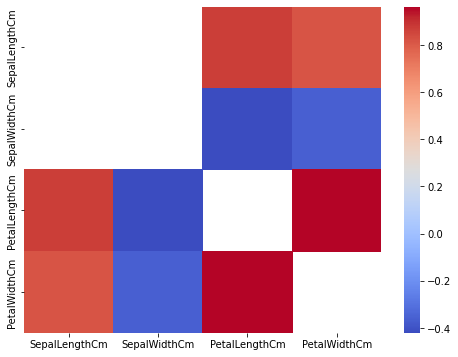

In [10]:
min_corr = 0.3
kot = rho[(abs(rho) >= min_corr) & (rho < 1)]
plt.figure(figsize=(8, 6))
sns.heatmap(kot, cmap=sns.color_palette("coolwarm", as_cmap=True)) 

#### Summing up

- After graphing the features in a pair plot, it is clear that the relationship between pairs of features of a iris-setosa (in pink) is distinctly different from those of the other two species.
- There is some overlap in the pairwise relationships of the other two species, iris-versicolor (brown) and iris-virginica (green).

# Modeling with scikit-learn

Preparing the dataset for the ML pipeline.
- X: the dataset
- y: the labels

In [11]:
X = df.drop(['Id', 'Species'], axis=1)
y = df['Species']
# print(X.head())
print(X.shape)
# print(y.head())
print(y.shape)

(150, 4)
(150,)


In [12]:
X

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [13]:
y

0         Iris-setosa
1         Iris-setosa
2         Iris-setosa
3         Iris-setosa
4         Iris-setosa
            ...      
145    Iris-virginica
146    Iris-virginica
147    Iris-virginica
148    Iris-virginica
149    Iris-virginica
Name: Species, Length: 150, dtype: object

## Train and test on the same dataset

- Pick a classifier from SKLearn (e.g., logistic regression, decision tree, random forest, k-NN classifier) and train your model on the entire dataset

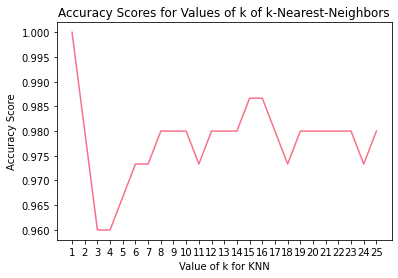

In [14]:
# experimenting with different n values
k_range = list(range(1,26))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)
    y_pred = knn.predict(X)
    scores.append(metrics.accuracy_score(y, y_pred))
    
plt.plot(k_range, scores)
plt.xticks(k_range)
plt.xlabel('Value of k for KNN')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Values of k of k-Nearest-Neighbors')
plt.show()

In [15]:
logreg = LogisticRegression()
logreg.fit(X, y)
y_pred = logreg.predict(X)
print(metrics.accuracy_score(y, y_pred))

0.9733333333333334


### Summing up

- Training on the entire dataset *is not* suggested since the end goal is to predict iris species using a dataset the model has not seen before.
- There is also a *high* risk of overfitting the training data.

## Split the dataset into a training set and a testing set

### Advantages
- By splitting the dataset pseudo-randomly into a two separate sets, we can train using one set and test using another.
- This ensures that we won't use the same observations in both sets.
- More flexible and faster than creating a model using all of the dataset for training.

### Disadvantages
- The accuracy scores for the testing set can vary depending on what observations are in the set. 
- This disadvantage can be countered using k-fold cross-validation.

### Notes
- The accuracy score of the models depends on the observations in the testing set, which is determined by the seed of the pseudo-random number generator (random_state parameter).
- As a model's complexity increases, the training accuracy (accuracy you get when you train and test the model on the same data) increases.
- If a model is too complex or not complex enough, the testing accuracy is lower.
- For KNN models, the value of k determines the level of complexity. A lower value of k means that the model is more complex.

Split the training and test sets such that the test set contains 40% of the data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(90, 4)
(90,)
(60, 4)
(60,)


Fit your model and try it with several parameters

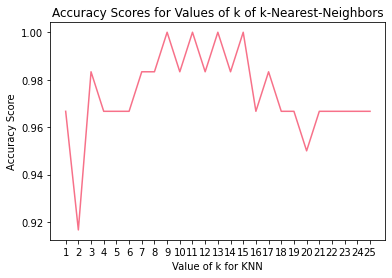

In [17]:
# experimenting with different n values
k_range = list(range(1,26))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))
    
plt.plot(k_range, scores)
plt.xticks(k_range)
plt.xlabel('Value of k for KNN')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Values of k of k-Nearest-Neighbors')
plt.show()

You can also try different models (check https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)

In [18]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.9833333333333333


Predict the outcome of an unseen observation (hint use the `.predict()` method)

In [19]:
# To train the model on the entire dataset
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(X, y)
y_pred = knn.predict(X)
metrics.accuracy_score(y, y_pred)

0.98

In [20]:
# make a prediction for an example of an out-of-sample observation
knn.predict([[6, 3, 4, 2]])

array(['Iris-versicolor'], dtype=object)

In [21]:
logreg.predict([[6, 3, 4, 2]])

array(['Iris-versicolor'], dtype=object)